# Problem Set #4
MACS 30250, Dr. Evans  
Minghao Yang

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import timeit

## 1. Exercise 2.1

In [2]:
# Define necessary functions
def U(c, sigma):
    return (c ** (1 - sigma) - 1) * (1 - sigma)

def MU(c, sigma):
    return c ** (-sigma)

def Y(K, L, A, alpha):
    return A * (K ** alpha) * (L ** (1 - alpha))

def r_opt(K, L, A, alpha, delta):
    return alpha * A * (L / K) ** (1 - alpha) - delta

def w_opt(K, L, A, alpha):
    return (1 - alpha) * A * (K / L) ** alpha

def L_clear(nvec):
    return nvec.sum()

def K_clear(bvec):
    return bvec.sum()

In [3]:
# Calibration
nvec = np.array([1, 1, 0.2])
beta = 0.96 ** 20
delta = 1 - (1 - 0.05) ** 20
sigma = 3
A = 1
alpha = 0.35

f_params = (nvec, A, alpha, delta)

In [4]:
# Define the feasible function
def feasible(f_params, bvec_guess):
    nvec, A, alpha, delta = f_params
    bvec = bvec_guess
    L = L_clear(nvec)
    K = K_clear(bvec)
    w = w_opt(K, L, A, alpha)
    r = r_opt(K, L, A, alpha, delta)
    c1 = nvec[0] * w - bvec[0]
    c2 = nvec[1] * w + (1 + r) * bvec[0] - bvec[1]
    c3 = nvec[2] * w + (1 + r) * bvec[1]
    
    return (np.array([c1 <= 0 or c2 <= 0, c2 <= 0]), 
            np.array([c1 <= 0, c2 <= 0, c3 <= 0]), 
            np.array([K <= 0]))

### (a)

In [5]:
feasible(f_params, np.array([1.0, 1.2]))

(array([ True, False]), array([ True, False, False]), array([False]))

The consumption should be nonnegative in period 1.

### (b)

In [6]:
feasible(f_params, np.array([0.06, -0.001]))

(array([False, False]), array([False, False, False]), array([False]))

Every constraint is satisfied.

### (c)

In [7]:
feasible(f_params, np.array([0.1, 0.1]))

(array([False, False]), array([False, False, False]), array([False]))

Every constraint is satisfied.

## 2. Exercise 2.2

In [8]:
# Define a function returning Euler equations
def Euler_eq(bvec, *args):
    beta, sigma, nvec, A, alpha, delta = args
    K = K_clear(bvec)
    L = L_clear(nvec)
    w = w_opt(K, L, A, alpha)
    r = r_opt(K, L, A, alpha, delta)
    c1 = nvec[0] * w - bvec[0]
    c2 = nvec[1] * w + (1 + r) * bvec[0] - bvec[1]
    c3 = nvec[2] * w + (1 + r) * bvec[1]
    MU1 = MU(c1, sigma)
    MU2 = MU(c2, sigma)
    MU3 = MU(c3, sigma)
    return np.array([MU1 - beta * (1 + r) * MU2, 
                     MU2 - beta * (1 + r) * MU3])

In [9]:
# Define the function for solving steady-states (The argument L in params is redundent, so I drop it)
def get_SS(params, bvec_guess, SS_graphs=True):
    beta, sigma, nvec, A, alpha, delta, SS_tol = params
    start_time = timeit.default_timer()
    args = (beta, sigma, nvec, A, alpha, delta)
    b_ss = opt.root(Euler_eq, bvec_guess, tol=SS_tol, args=(args)).x
    K_ss = K_clear(b_ss)
    L_ss = L_clear(nvec)
    w_ss = w_opt(K_ss, L_ss, A, alpha)
    r_ss = r_opt(K_ss, L_ss, A, alpha, delta)
    c1_ss = nvec[0] * w_ss - b_ss[0]
    c2_ss = nvec[1] * w_ss + (1 + r_ss) * b_ss[0] - b_ss[1]
    c3_ss = nvec[2] * w_ss + (1 + r_ss) * b_ss[1]
    c_ss = np.array([c1_ss, c2_ss, c3_ss])
    Y_ss = Y(K_ss, L_ss, A, alpha)
    C_ss = c_ss.sum()
    EulErr_ss = Euler_eq(b_ss, *args)
    RCerr_ss = Y_ss - C_ss - delta * K_ss      
    ss_time = timeit.default_timer() - start_time
    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss, 
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss, 
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss, 
        'ss_time': ss_time 
    }
    
    if SS_graphs:
        x = np.arange(3)
        plt.bar(x, c_ss)
        plt.xticks(x, ('$c_{1}$', '$c_{2}$', '$c_{3}$'))
        plt.title('Steady-state distribution of consumption')
        plt.show()
        plt.bar(x, [0, b_ss[0], b_ss[1]])
        plt.xticks(x, (' ', '$b_{2}$', '$b_{3}$'))
        plt.title('Steady-state distribution of savings')
        plt.show()
    
    return ss_output   

### (a) & (b)

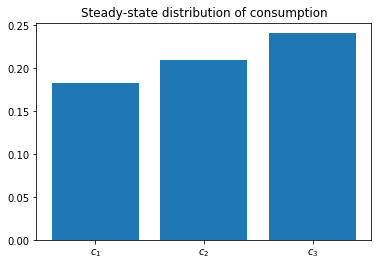

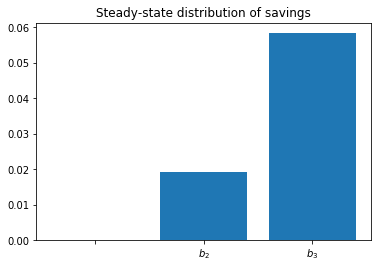

{'b_ss': array([0.01931274, 0.05841159]),
 'c_ss': array([0.18241256, 0.20961491, 0.24087382]),
 'w_ss': 0.2017252935955733,
 'r_ss': 2.4330302535646116,
 'K_ss': 0.07772432611811347,
 'Y_ss': 0.6827625321696328,
 'C_ss': 0.6329012827935535,
 'EulErr_ss': array([-1.33582034e-12,  2.67164069e-12]),
 'RCerr_ss': 3.469446951953614e-17,
 'ss_time': 0.001258999999999677}

In [10]:
SS_tol = 1e-10
params = (beta, sigma, nvec, A, alpha, delta, SS_tol)
get_SS(params, np.array([0.1, 0.1]), SS_graphs=True)

### (c)

In [11]:
params = (0.55, sigma, nvec, A, alpha, delta, SS_tol)
get_SS(params, np.array([0.1, 0.1]), SS_graphs=False)

{'b_ss': array([0.02817696, 0.07686557]),
 'c_ss': array([0.19597535, 0.22861559, 0.26669216]),
 'w_ss': 0.22415231191003315,
 'r_ss': 1.8863599991452351,
 'K_ss': 0.10504252550764615,
 'Y_ss': 0.7586693633878046,
 'C_ss': 0.6912831045288896,
 'EulErr_ss': array([-2.84217094e-14, -2.84217094e-14]),
 'RCerr_ss': 9.71445146547012e-17,
 'ss_time': 0.0006210000000002047}

Compared with (a), $\bar{c}_1$, $\bar{c}_2$, $\bar{c}_3$, $\bar{b}_2$, $\bar{b}_3$, and $\bar{w}$ increase, but $\bar{r}$ decreases. If $\beta$ becomes larger, households will become more patient, so they are willing to save more and consume in later periods. Hence, the wealth of each household becomes higher, enabling them to consume more in each period. Given that more capital is available in the market, the price of capital will fall. On the other hand, the marginal productivity of labor increases because each labor unit is assigned with more capital, so wage will also increase in equilibrium. 

## 3. Exercise 2.3

In [12]:
# Initialize parameters
T = 40
m = 8
epsilon = 1e-9
xi = 0.1
params = (beta, sigma, nvec, A, alpha, delta, SS_tol)
b_ss = get_SS(params, np.array([0.1, 0.1]), SS_graphs=False)['b_ss']
b21, b31 = (0.8 * b_ss[0], 1.1 * b_ss[1])
K1 = K_clear(np.array([b21, b31]))
K_ss = K_clear(b_ss)

In [13]:
# Define the Euler equations
def Euler_eq_first_period(b32, *args):
    b21, w_path, r_path, beta, sigma, nvec = args
    c2 = nvec[1] * w_path[0] + (1 + r_path[0]) * b21 - b32
    c3 = nvec[2] * w_path[1] + (1 + r_path[1]) * b32
    MU2 = MU(c2, sigma)
    MU3 = MU(c3, sigma)
    return MU2 - beta * (1 + r_path[1]) * MU3

def Euler_eq_other_periods(bvec, *args):
    t, w_path, r_path, beta, sigma, nvec = args
    c1 = nvec[0] * w_path[t - 1] - bvec[0]
    c2 = nvec[1] * w_path[t] + (1 + r_path[t]) * bvec[0] - bvec[1]
    c3 = nvec[2] * w_path[t + 1] + (1 + r_path[t + 1]) * bvec[1]
    MU1 = MU(c1, sigma)
    MU2 = MU(c2, sigma)
    MU3 = MU(c3, sigma)
    return np.array([MU1 - beta * (1 + r_path[t]) * MU2, MU2 - beta * (1 + r_path[t + 1]) * MU3])

In [14]:
# Define a funtion to calculate the path of capital
def K_path_prime_cal(T, params, bvec_guess):
    b21, b31, K_path, L_path, beta, sigma, nvec, A, alpha, delta, SS_tol = params
    w_path = w_opt(K_path, L_path, A, alpha)
    r_path = r_opt(K_path, L_path, A, alpha, delta)
    K_path_prime = [0] * (T - 1)
    C_path_prime = [0] * (T - 1)
    EulErr_path_prime_2 = [0]
    EulErr_path_prime_3 = []
    b2_path_prime = [b21]
    b3_path_prime = [b31]
    c1_path_prime = [0] * (T - 1)
    c2_path_prime = [0] * T
    c3_path_prime = [nvec[2] * w_path[0] + (1 + r_path[0]) * b31] + [0] * T
    for t in range(T - 1):
        if t == 0: # solve for b32
            args = (b21, w_path, r_path, beta, sigma, nvec)
            # saving path
            b32 = opt.root(Euler_eq_first_period, bvec_guess[1], tol=SS_tol, args=(args)).x[0]
            b3_path_prime.append(b32)
            # consumption path
            c2 = nvec[1] * w_path[0] + (1 + r_path[0]) * b21 - b32
            c3 = nvec[2] * w_path[1] + (1 + r_path[1]) * b32
            c2_path_prime[t] = c2
            c3_path_prime[t + 1] = c3
            # Euler equation errors path
            EulErr_path_prime_3.append(abs(Euler_eq_first_period(b32, *args)))
        else: # solve for b_{t+1, 2} and b_{t+2, 3}
            args = (t, w_path, r_path, beta, sigma, nvec)
            # saving and capital path
            btp12, btp23 = opt.root(Euler_eq_other_periods, bvec_guess, tol=SS_tol, args=(args)).x
            b2_path_prime.append(btp12)
            b3_path_prime.append(btp23)
            K_path_prime[t - 1] = b2_path_prime[t - 1] + b3_path_prime[t - 1]
            # consumption path
            c1 = nvec[0] * w_path[t - 1] - btp12
            c2 = nvec[1] * w_path[t] + (1 + r_path[t]) * btp12 - btp23
            c3 = nvec[2] * w_path[t + 1] + (1 + r_path[t + 1]) * btp23
            c1_path_prime[t - 1] = c1
            c2_path_prime[t] = c2
            c3_path_prime[t + 1] = c3
            C_path_prime[t - 1] = c1_path_prime[t - 1] + c2_path_prime[t - 1] + c3_path_prime[t - 1]
            # Euler equation errors path
            EulErr_path_prime_2.append(abs(Euler_eq_other_periods(np.array([btp12, btp23]), *args)[0]))
            EulErr_path_prime_3.append(abs(Euler_eq_other_periods(np.array([btp12, btp23]), *args)[1]))
    # Production path
    Y_path_prime = Y(np.array(K_path_prime)[:T - 3], L_path[:T - 3], A, alpha)
    # Recourse constraint path
    RCerr_path_prime = abs(Y_path_prime - np.array(C_path_prime)[:T - 3] 
                           - np.array(K_path_prime)[1: T - 2] 
                           + (1 - delta) * np.array(K_path_prime)[:T - 3])
    return (np.array(K_path_prime)[:T - 3], 
            np.array([max(EulErr_path_prime_2[:T - 3]), max(EulErr_path_prime_3[:T - 3])]), 
            np.array([max(RCerr_path_prime)]))

In [15]:
# Solve the problem by TPI
K_path = np.linspace(K1, K_ss, T)
K_path = np.append(K_path, np.array([K_ss] * m))
L_path = np.ones(T + m) * L_clear(nvec)
i = 0
max_iter = 200
while True:
    params = np.array([b21, b31, K_path, L_path, beta, sigma, nvec, A, alpha, delta, SS_tol])
    K_path_prime, max_EulErr, max_RCerr = K_path_prime_cal(T + m, params, np.array([0.1, 0.1]))
    K_dist = ((K_path[:40] - K_path_prime[:40]) ** 2).sum()
    print("Iteration {}: The distance between K and K_prime is {}".format(i + 1, K_dist))
    if K_dist < epsilon:
        print("The algorithm converges after {} iterations.".format(i + 1))
        print("The maximum of the absolute values of all the Euler errors",  
              "across the entire time path are {}.".format(max_EulErr))
        print("The maximum of the absolute value of all the resource constraint errors", 
              "across the entire time path is {}.".format(max_RCerr))
        break
    else:
        K_path = xi * K_path_prime + (1 - xi) * K_path[:K_path_prime.shape[0]]
        K_path = np.append(K_path, [K_ss] * (T + m - K_path_prime.shape[0]))
        i += 1
    if i >= max_iter:
        print("The algorithm fails to converge after {} iterations.".format(i + 1))
    

Iteration 1: The distance between K and K_prime is 3.331457480072446e-05
Iteration 2: The distance between K and K_prime is 2.806693412109667e-05
Iteration 3: The distance between K and K_prime is 2.374978057984588e-05
Iteration 4: The distance between K and K_prime is 2.01805673635834e-05
Iteration 5: The distance between K and K_prime is 1.7215321892317838e-05
Iteration 6: The distance between K and K_prime is 1.4740076313475471e-05
Iteration 7: The distance between K and K_prime is 1.2664265771302853e-05
Iteration 8: The distance between K and K_prime is 1.091563231017859e-05
Iteration 9: The distance between K and K_prime is 9.436282569482064e-06
Iteration 10: The distance between K and K_prime is 8.179631085675833e-06
Iteration 11: The distance between K and K_prime is 7.108024525412868e-06
Iteration 12: The distance between K and K_prime is 6.190890432227406e-06
Iteration 13: The distance between K and K_prime is 5.403290779247455e-06
Iteration 14: The distance between K and K_pr

### (b)

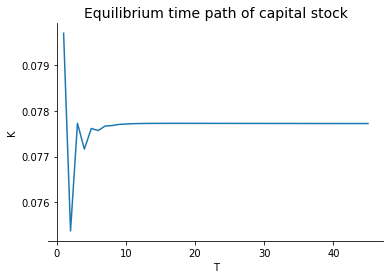

In [16]:
# Capital stock
ax = plt.gca()
ax.plot(range(1, T + 6), K_path_prime[: T + 5])
ax.set_title("Equilibrium time path of capital stock", fontsize=14)
ax.set_xlabel("T")
ax.set_ylabel("K")
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)
plt.show()

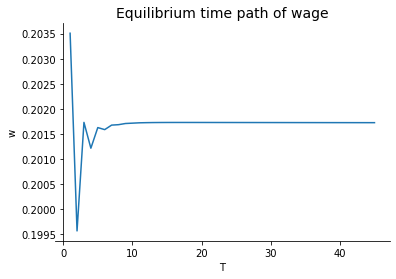

In [17]:
# Wage
ax = plt.gca()
ax.plot(range(1, T + 6), w_opt(K_path_prime[: T + 5], L_path[: T + 5], A, alpha))
ax.set_title("Equilibrium time path of wage", fontsize=14)
ax.set_xlabel("T")
ax.set_ylabel("w")
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)
plt.show()

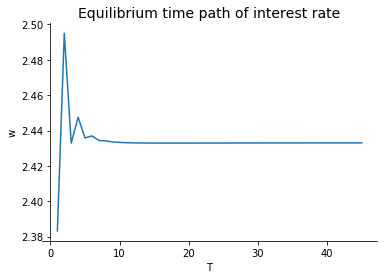

In [18]:
# Interest rate
ax = plt.gca()
ax.plot(range(1, T + 6), r_opt(K_path_prime[: T + 5], L_path[: T + 5], A, alpha, delta))
ax.set_title("Equilibrium time path of interest rate", fontsize=14)
ax.set_xlabel("T")
ax.set_ylabel("w")
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)
plt.show()

### (c)

In [19]:
K_div = abs(K_path_prime - np.array([K_ss] * K_path_prime.shape[0]))
loc1 = np.where(K_div < 1e-5)[0]
print("It takes {} periods for the economy to deviate within the range of".format(loc1.min()), 
      "0.00001 from the steady-state capital stock the first time.")
for i in range(len(K_path_prime)):
    if K_div[i] <= 1e-5:
        mark_allinrange = 1
        for j in range(i + 1, len(K_path_prime)):
            if K_div[j] > 1e-5:
                mark_allinrange = 0
                break
        if mark_allinrange:
            print("It takes {} periods for the economy to deviate within the range of".format(i), 
                  "0.00001 from the steady-state capital stock after that.")
            break

It takes 2 periods for the economy to deviate within the range of 0.00001 from the steady-state capital stock the first time.
It takes 10 periods for the economy to deviate within the range of 0.00001 from the steady-state capital stock after that.
